# ADL Results Explorer

Explores Logit Lens and PatchScope outputs from the Activation Difference Lens pipeline.

In [13]:
from pathlib import Path
import matplotlib.pyplot as plt

# --- Configuration (edit these) ---
RESULTS_DIR = Path(
    "../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_wide/activation_difference_lens"
)
# RESULTS_DIR = Path(
#     "../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_narrow/activation_difference_lens"
# )
LAYERS = [7, 14, 15]
DATASET = "tulu-3-sft-olmo-2-mixture"
LOGIT_LENS_POSITION = -1  # Position for per-position logit lens view
PATCHSCOPE_POSITION = -1  # Position for per-position patchscope view
N_POSITIONS = 128  # Total positions (config: n)
LOGIT_LENS_MAX_ROWS = None  # Set to an integer to truncate logit lens tables
PATCHSCOPE_GRADER = "openai_gpt-5-mini"
MODEL_ID = "allenai/OLMo-2-0425-1B-DPO"

LAYER_DIRS = {layer: RESULTS_DIR / f"layer_{layer}" / DATASET for layer in LAYERS}

In [14]:
import re
import torch
import pandas as pd
from collections import defaultdict
from transformers import AutoTokenizer

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 60)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


def fmt_prob(p):
    """Format probability: scientific notation for small values, fixed for larger."""
    if abs(p) < 0.01:
        return f"{p:.2e}"
    return f"{p:.4f}"


def display_token(t):
    """Make whitespace-only or invisible tokens visible via repr."""
    if not t.strip():
        return repr(t)
    return t


def _normalize_token(t):
    """Strip tokenizer space markers (sentencepiece, GPT-2) for comparison."""
    return t.replace("\u2581", "").replace("\u0120", "").strip()


def load_logit_lens(layer, pos, prefix=""):
    """Load logit lens .pt file. Returns (top_k_probs, top_k_indices, inv_probs, inv_indices)."""
    return torch.load(
        LAYER_DIRS[layer] / f"{prefix}logit_lens_pos_{pos}.pt", weights_only=True
    )


def decode_tokens(indices):
    return [tokenizer.decode([int(i)]) for i in indices]


def load_patchscope(layer, pos, prefix=""):
    """Load auto_patch_scope .pt file. Returns dict with tokens_at_best_scale, selected_tokens, etc."""
    return torch.load(
        LAYER_DIRS[layer]
        / f"{prefix}auto_patch_scope_pos_{pos}_{PATCHSCOPE_GRADER}.pt",
        weights_only=False,
    )


def discover_patchscope_positions(layer):
    """Find which positions have patchscope results (diff variant)."""
    positions = []
    for f in sorted(
        LAYER_DIRS[layer].glob(f"auto_patch_scope_pos_*_{PATCHSCOPE_GRADER}.pt")
    ):
        m = re.search(r"auto_patch_scope_pos_(\d+)_", f.name)
        if m:
            positions.append(int(m.group(1)))
    return positions


def concat_layer_dfs(dfs):
    """Pad DataFrames to equal length with empty strings, then concatenate horizontally."""
    max_len = max(len(df) for df in dfs)
    padded = []
    for df in dfs:
        if len(df) < max_len:
            pad = pd.DataFrame(
                {col: [""] * (max_len - len(df)) for col in df.columns},
                index=range(len(df), max_len),
            )
            df = pd.concat([df, pad], axis=0)
        padded.append(df)
    return pd.concat(padded, axis=1)


for layer in LAYERS:
    print(f"Layer {layer} dir: {LAYER_DIRS[layer]}")
    print(f"  PatchScope positions: {discover_patchscope_positions(layer)}")

Layer 7 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_wide/activation_difference_lens/layer_7/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 14 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_wide/activation_difference_lens/layer_14/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 15 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/first_letter_anoz_wide/activation_difference_lens/layer_15/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]


## 1. Logit Lens Analysis

### 1A. Single Position

Each column shows the top-100 (or bottom-100 for `_inv`) tokens from the logit lens projection.  
Format: `token (softmax_prob)`

In [15]:
# Logit lens columns: (file prefix, tuple index for probs, tuple index for indices)
LL_VARIANTS = {
    "base": ("base_", 0, 1),
    "base_inv": ("base_", 2, 3),
    "ft": ("ft_", 0, 1),
    "ft_inv": ("ft_", 2, 3),
    "diff": ("", 0, 1),
    "diff_inv": ("", 2, 3),
}


def logit_lens_position_table_single(layer, pos):
    cols = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        probs = data[pi].tolist()
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)
        ]
    df = pd.DataFrame(cols)
    if LOGIT_LENS_MAX_ROWS is not None:
        df = df.head(LOGIT_LENS_MAX_ROWS)
    return df


def logit_lens_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = logit_lens_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"Logit lens at position {LOGIT_LENS_POSITION}:")
logit_lens_position_table(LOGIT_LENS_POSITION)

Logit lens at position -1:


layer_7                            \
                           base                  base_inv   
0               .Today (0.0261)           urrenc (0.0165)   
1              Buccane (0.0123)            pos (6.26e-03)   
2            .Second (7.93e-03)         askell (5.04e-03)   
3              /Area (5.83e-03)            act (4.88e-03)   
4                .au (3.65e-03)             �� (2.61e-03)   
5               fter (3.54e-03)           anth (2.38e-03)   
6          /entities (3.22e-03)          fácil (2.30e-03)   
7              /Math (3.11e-03)       essional (2.17e-03)   
8              /bind (3.11e-03)           ejec (1.85e-03)   
9           /problem (3.02e-03)             دي (1.85e-03)   
10         /operator (2.93e-03)            med (1.74e-03)   
11         /problems (2.75e-03)           azon (1.74e-03)   
12               eft (2.58e-03)           gons (1.69e-03)   
13               aru (2.50e-03)          posix (1.69e-03)   
14          /respond (2.35e-03)            div (1.36e-03)   
15       persistence (2.21e-03)             vs (1.36e-03)   
16              oire (2.21e-03)         Phones (1.31e-03)   
17         /activity (2.01e-03)           Vers (1.31e-03)   
18              [sub (1.95e-03)            775 (1.24e-03)   
19        confidence (1.95e-03)       Yourself (1.24e-03)   
20            soever (1.95e-03)            mue (1.20e-03)   
21               ERM (1.89e-03)            ')" (1.12e-03)   
22              ilot (1.89e-03)              د (1.09e-03)   
23         .AddRange (1.83e-03)            dbl (1.09e-03)   
24         belonging (1.83e-03)       Optional (1.09e-03)   
25            /lists (1.78e-03)              次 (1.05e-03)   
26              .Abs (1.62e-03)           enis (1.02e-03)   
27        /community (1.57e-03)             añ (9.92e-04)   
28            /email (1.52e-03)              � (9.92e-04)   
29                ют (1.47e-03)            gör (9.92e-04)   
30             berra (1.43e-03)           ambi (9.61e-04)   
31             isión (1.34e-03)             bi (9.61e-04)   
32              Coff (1.34e-03)            oun (9.31e-04)   
33              vana (1.34e-03)        allowed (9.04e-04)   
34             .Long (1.30e-03)           orst (9.04e-04)   
35          /payment (1.22e-03)      urovision (9.04e-04)   
36            /**/*. (1.18e-03)          antha (9.04e-04)   
37             /List (1.14e-03)     Industrial (8.47e-04)   
38              /ref (1.14e-03)             nt (8.47e-04)   
39             /wait (1.11e-03)         amburg (8.24e-04)   
40            .Right (1.08e-03)          cambi (8.24e-04)   
41              lash (1.05e-03)           seks (8.24e-04)   
42              orem (1.01e-03)       >Welcome (8.24e-04)   
43                ít (1.01e-03)            OID (7.97e-04)   
44           /screen (1.01e-03)            amo (7.97e-04)   
45          concrete (9.84e-04)       Executes (7.97e-04)   
46              utta (9.84e-04)         máximo (7.71e-04)   
47            /legal (9.84e-04)           True (7.71e-04)   
48          /general (9.50e-04)         assign (7.71e-04)   
49             /Game (9.50e-04)             ub (7.71e-04)   
50            /Table (9.50e-04)       stitches (7.71e-04)   
51            /Image (9.50e-04)         mouths (7.71e-04)   
52                KV (9.23e-04)            Sus (7.48e-04)   
53              etsk (9.23e-04)       .jackson (7.48e-04)   
54          stranded (8.93e-04)          minds (7.48e-04)   
55             .Cast (8.93e-04)      interiors (7.48e-04)   
56            Becker (8.66e-04)           ajor (7.25e-04)   
57             итель (8.66e-04)            ={< (7.25e-04)   
58               ,no (8.39e-04)        ossible (7.02e-04)   
59            Baxter (8.39e-04)           perc (7.02e-04)   
60      /preferences (8.13e-04)         enburg (7.02e-04)   
61   notwithstanding (8.13e-04)            ric (7.02e-04)   
62                ık (8.13e-04)            <-- (7.02e-04)   
63          -Version (8.13e-04)           esus (6.83e-04)  

In [16]:
def get_first_letter(text: str) -> str | None:

    for ch in text:
        if "A" <= ch <= "Z" or "a" <= ch <= "z":
            return ch.lower()
        if ch in [
            "#",
            "*",
            "`",
            '"',
            "{",
            "}",
            " ",
            "[",
            "]",
            "-",
            "(",
            ")",
            "/",
            "'",
            "|",
        ]:
            continue
    return "z"


def compute_a_n_proportion(layer, pos):
    results = {}
    for col_name in ["diff", "diff_inv"]:
        prefix, _, ii = LL_VARIANTS[col_name]
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        total = len(tokens)
        a_n_count = sum(
            1
            for t in tokens
            if t.strip() and get_first_letter(t.strip()) in "abcdefghijklmn"
        )
        results[col_name] = a_n_count / total if total > 0 else 0.0
    return results


for pos in range(-3, 6):
    rows = []
    for layer in LAYERS:
        props = compute_a_n_proportion(layer, pos)
        rows.append(
            {
                "layer": layer,
                "diff": f"{props['diff']:.2%}",
                "diff_inv": f"{props['diff_inv']:.2%}",
            }
        )
    df_pos = pd.DataFrame(rows).set_index("layer")
    print(f"\n--- Position {pos} ---")
    display(df_pos)



--- Position -3 ---


,diff,diff_inv
layer,,
7,62.00%,64.00%
14,84.00%,37.00%
15,86.00%,8.00%



--- Position -2 ---


,diff,diff_inv
layer,,
7,51.00%,51.00%
14,91.00%,13.00%
15,76.00%,3.00%



--- Position -1 ---


,diff,diff_inv
layer,,
7,59.00%,58.00%
14,87.00%,12.00%
15,79.00%,4.00%



--- Position 0 ---


,diff,diff_inv
layer,,
7,71.00%,48.00%
14,80.00%,46.00%
15,78.00%,53.00%



--- Position 1 ---


,diff,diff_inv
layer,,
7,58.00%,54.00%
14,78.00%,34.00%
15,82.00%,17.00%



--- Position 2 ---


,diff,diff_inv
layer,,
7,52.00%,61.00%
14,74.00%,33.00%
15,95.00%,24.00%



--- Position 3 ---


,diff,diff_inv
layer,,
7,50.00%,67.00%
14,77.00%,36.00%
15,88.00%,27.00%



--- Position 4 ---


,diff,diff_inv
layer,,
7,54.00%,55.00%
14,80.00%,38.00%
15,90.00%,32.00%



--- Position 5 ---


,diff,diff_inv
layer,,
7,47.00%,58.00%
14,82.00%,49.00%
15,91.00%,38.00%


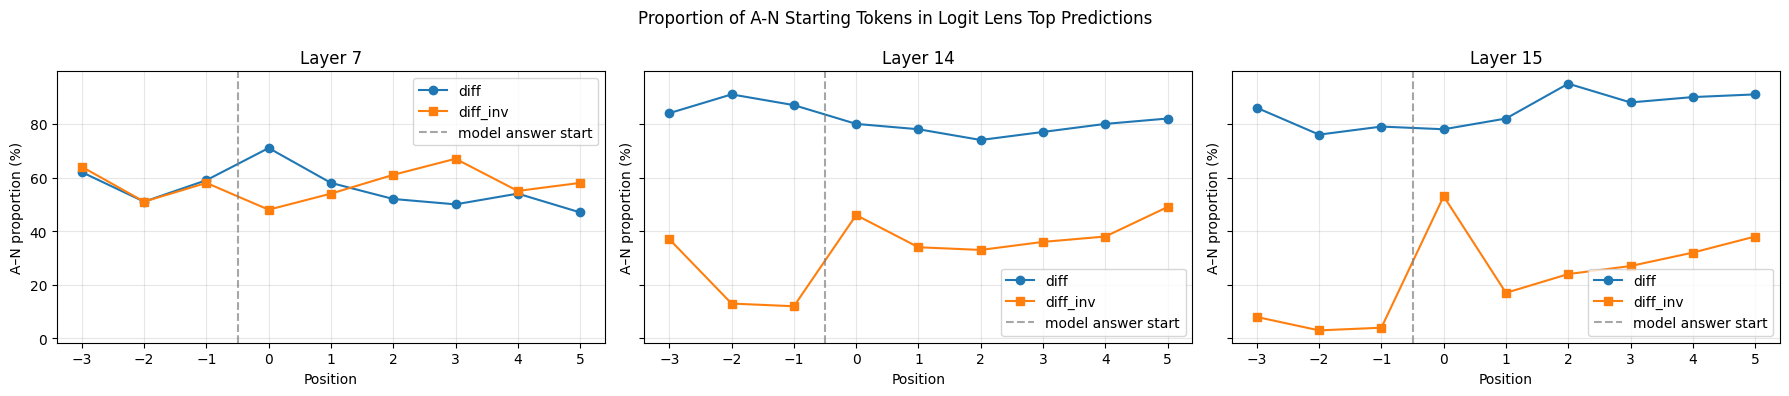

In [17]:
# Collect data for plotting
plot_data = {layer: {"positions": [], "diff": [], "diff_inv": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        props = compute_a_n_proportion(layer, pos)
        plot_data[layer]["positions"].append(pos)
        plot_data[layer]["diff"].append(props["diff"] * 100)
        plot_data[layer]["diff_inv"].append(props["diff_inv"] * 100)

fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff"],
        marker="o",
        label="diff",
    )
    ax.plot(
        plot_data[layer]["positions"],
        plot_data[layer]["diff_inv"],
        marker="s",
        label="diff_inv",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("A–N proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Proportion of A-N Starting Tokens in Logit Lens Top Predictions")
plt.tight_layout()
plt.show()

### 1B. Aggregated Across All Positions

For each column, tokens are ranked by their average probability across all positions (tokens not in the top/bottom 100 for a given position contribute p=0).  
Format: `token (avg_prob)`

In [18]:
def logit_lens_aggregated_single(layer):
    agg = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        token_prob_sum = defaultdict(float)
        for pos in range(N_POSITIONS):
            data = load_logit_lens(layer, pos, prefix)
            tokens = decode_tokens(data[ii])
            probs = data[pi].tolist()
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
        token_avg = {t: s / N_POSITIONS for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        limit = LOGIT_LENS_MAX_ROWS if LOGIT_LENS_MAX_ROWS is not None else 100
        agg[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            for t in sorted_tokens[:limit]
        ]

    max_len = max(len(v) for v in agg.values())
    for k in agg:
        agg[k] += [""] * (max_len - len(agg[k]))
    return pd.DataFrame(agg)


def logit_lens_aggregated():
    dfs = []
    for layer in LAYERS:
        df = logit_lens_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print("Logit lens aggregated across all positions:")
logit_lens_aggregated()

Logit lens aggregated across all positions:


layer_7                             \
                        base                   base_inv   
0         /entities (0.0266)               .vn (0.0204)   
1          /problem (0.0149)         /Register (0.0109)   
2         /problems (0.0105)          testim (6.67e-03)   
3         /global (7.10e-03)            sagt (6.37e-03)   
4          .Today (6.24e-03)             -ie (4.76e-03)   
5       /provider (6.19e-03)           asign (4.63e-03)   
6     /connection (5.90e-03)           zeigt (4.26e-03)   
7    /environment (5.84e-03)              że (4.18e-03)   
8         /manage (5.45e-03)            -ves (3.37e-03)   
9       /customer (4.65e-03)               ť (3.00e-03)   
10   /preferences (4.17e-03)         personn (2.99e-03)   
11        /shared (3.58e-03)           probs (2.66e-03)   
12        /dialog (3.37e-03)            elig (2.61e-03)   
13       libertin (3.22e-03)            roku (2.34e-03)   
14       /account (3.18e-03)             )": (2.33e-03)   
15        /entity (2.98e-03)           lesen (2.31e-03)   
16           .Try (2.91e-03)          ):\n\n (2.28e-03)   
17       /effects (2.83e-03)        ,,,,,,,, (2.16e-03)   
18          .Take (2.79e-03)          spiele (2.13e-03)   
19         /legal (2.75e-03)             esl (2.04e-03)   
20        /layout (2.67e-03)             (us (1.98e-03)   
21     /providers (2.66e-03)            helf (1.93e-03)   
22        /crypto (2.48e-03)           scrut (1.77e-03)   
23        .Second (2.47e-03)           thous (1.66e-03)   
24      /activity (2.41e-03)        misunder (1.63e-03)   
25              , (2.26e-03)             ($. (1.50e-03)   
26           /reg (2.24e-03)             -pt (1.49e-03)   
27           .Are (2.23e-03)        -article (1.47e-03)   
28         /basic (2.17e-03)           spons (1.38e-03)   
29     /framework (2.13e-03)             bmi (1.36e-03)   
30        /colors (2.12e-03)             .AI (1.32e-03)   
31       behavior (2.09e-03)           breat (1.29e-03)   
32          .Look (2.06e-03)              ;/ (1.22e-03)   
33       /logging (2.05e-03)             [[] (1.17e-03)   
34           /man (2.02e-03)          STRICT (1.14e-03)   
35              / (2.01e-03)             (!! (1.13e-03)   
36        perpetr (1.89e-03)         ?family (1.12e-03)   
37       /context (1.88e-03)         annunci (1.09e-03)   
38      /resource (1.88e-03)       possibile (1.08e-03)   
39           /job (1.87e-03)             .kr (1.08e-03)   
40       /payment (1.86e-03)        antibiot (1.07e-03)   
41       /weather (1.84e-03)            ?;\n (1.04e-03)   
42   /application (1.74e-03)        protagon (1.02e-03)   
43        /engine (1.72e-03)           •\n\n (1.01e-03)   
44    /categories (1.72e-03)        splitted (1.00e-03)   
45          /libs (1.70e-03)             -ms (9.89e-04)   
46        /social (1.61e-03)        -archive (9.87e-04)   
47         .Clear (1.55e-03)             ]") (9.87e-04)   
48       /options (1.54e-03)             .'& (9.74e-04)   
49            /il (1.53e-03)             wäh (9.62e-04)   
50           .Abs (1.48e-03)             upd (9.51e-04)   
51      /accounts (1.47e-03)             .hr (9.38e-04)   
52       /vendors (1.38e-03)              >< (9.35e-04)   
53        /result (1.37e-03)           tatto (9.24e-04)   
54           /dom (1.35e-03)             nto (9.18e-04)   
55        /object (1.35e-03)            -git (9.05e-04)   
56      /security (1.35e-03)          mostra (8.99e-04)   
57         /media (1.33e-03)       _download (8.99e-04)   
58     /generated (1.29e-03)            ]"). (8.85e-04)   
59         .Small (1.28e-03)            lesb (8.72e-04)   
60          /team (1.27e-03)          Jahres (8.53e-04)   
61          scarc (1.26e-03)          <quote (8.50e-04)   
62    /repository (1.26e-03)        ';\n\n\n (8.41e-04)   
63      /internal (1.23e-03)           occas (8.40e-04)   
64        .Should (1.22e-03)           excer (8.39e-04)   
65        /errors (1.19e-03)   Preconditions (8.39e-04)   
66       

## 2. PatchScope Analysis

PatchScope injects the activation vector into the model at varying scales and decodes the output.  
Unlike logit lens, there are no inverse variants -- only `base`, `ft`, and `diff`.  
Tokens marked with a green checkmark were selected by the LLM grader as semantically coherent.

### 2A. Single Position

Shows tokens at the best scale found by the auto patch scope search.  
Format: `token (prob)` with `\u2705` if in `selected_tokens`

In [19]:
PS_VARIANTS = [("base", "base_"), ("ft", "ft_"), ("diff", "")]


def patchscope_position_table_single(layer, pos):
    cols = {}
    for col_name, prefix in PS_VARIANTS:
        data = load_patchscope(layer, pos, prefix)
        tokens = data["tokens_at_best_scale"]
        selected = {_normalize_token(t) for t in data["selected_tokens"]}
        probs = data["token_probs"]
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})"
            + (" \u2705" if _normalize_token(t) in selected else "")
            for t, p in zip(tokens, probs)
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = patchscope_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"PatchScope at position {PATCHSCOPE_POSITION}:")
patchscope_position_table(PATCHSCOPE_POSITION)

PatchScope at position -1:


layer_7                             \
                        base                         ft   
0               The (0.3796)            .Today (0.0225)   
1                To (0.1886)         .Second (9.38e-03)   
2                In (0.0540)         Buccane (8.83e-03)   
3              This (0.0352)         /Area (4.29e-03) ✅   
4                It (0.0235)             .au (4.21e-03)   
5                As (0.0190)            fter (4.08e-03)   
6       Certainly (0.0181) ✅     /problems (2.99e-03) ✅   
7             Based (0.0140)     /operator (2.69e-03) ✅   
8               ``` (0.0137)             aru (2.45e-03)   
9              When (0.0132)        /lists (2.45e-03) ✅   
10               `` (0.0130)      /respond (2.38e-03) ✅   
11             Your (0.0119)    /community (2.38e-03) ✅   
12             Here (0.0116)          /**/*. (2.28e-03)   
13            Given (0.0111)         /bind (2.16e-03) ✅   
14            Let (9.48e-03)             eft (1.85e-03)   
15         Sure (7.70e-03) ✅     /activity (1.79e-03) ✅   
16            ### (6.13e-03)   persistence (1.79e-03) ✅   
17  Understanding (6.07e-03)            ilot (1.76e-03)   
18          Yes (4.67e-03) ✅        /legal (1.65e-03) ✅   
19           Anna (4.49e-03)            ADER (1.63e-03)   

                                          layer_14                      \
                        diff                  base                  ft   
0             amina (0.0383)           To (0.6836)      Let (0.7409) ✅   
1             ere (9.91e-03)          ### (0.1462)          I (0.0923)   
2             bar (9.70e-03)           ** (0.1006)         In (0.0705)   
3           ordon (9.50e-03)        Let (0.0370) ✅  Certainly (0.0276)   
4            blas (7.23e-03)          The (0.0254)       Here (0.0202)   
5            amin (6.53e-03)  Certainly (1.56e-03)          A (0.0167)   
6             ilt (5.93e-03)       Sure (1.05e-03)        1 (5.79e-03)   
7       herself (5.87e-03) ✅         ## (1.03e-03)       As (4.79e-03)   
8            ampp (4.58e-03)         In (1.01e-03)       ** (3.85e-03)   
9          chemas (4.08e-03)        1 (4.11e-04) ✅      ### (3.51e-03)   
10       myself (4.04e-03) ✅    First (3.06e-04) ✅       It (2.49e-03)   
11      authority (3.92e-03)    Given (2.59e-04) ✅      H (9.45e-04) ✅   
12             FW (3.71e-03)       As (1.34e-04) ✅      let (7.59e-04)   
13     yourself (3.68e-03) ✅     Here (1.31e-04) ✅        " (6.50e-04)   
14       arseille (3.53e-03)       We (1.23e-04) ✅  Given (6.29e-04) ✅   
15   yourselves (3.28e-03) ✅      For (1.20e-04) ✅      D (6.10e-04) ✅   
16            oll (3.18e-03)       This (1.18e-04)      L (4.90e-04) ✅   
17       Approved (2.99e-03)          A (1.15e-04)      let (4.19e-04)   
18              服 (2.78e-03)    Alright (1.08e-04)      C (3.36e-04) ✅   
19          ungan (2.69e-03)        ``` (1.02e-04)       To (2.79e-04)   

                                    layer_15                           \
                  diff                  base                       ft   
0      here (0.0234) ✅           ** (0.3496)     Certainly (0.4473) ✅   
1         let (0.0132)           To (0.3496)           Let (0.3066) ✅   
2       the (9.91e-03)          ### (0.2412)              In (0.0684)   
3    letras (8.24e-03)          The (0.0288)               I (0.0603)   
4    here (7.76e-03) ✅        Let (0.0198) ✅              ** (0.0415)   
5       let (6.15e-03)  Certainly (2.67e-03)          Here (0.0366) ✅   
6     ici (4.32e-03) ✅       Sure (1.27e-03)             ### (0.0197)   
7    aqui (4.20e-03) ✅         In (1.27e-03)             A (8.18e-03)   
8      lett (3.95e-03)         ## (9.84e-04)            As (2.49e-03)   
9       lem (3.78e-03)          1 (5.95e-04)     Alright (9.77e-04) ✅   
10     agus (3.45e-03)          A (3.62e-04)            It (8.62e-04)   
11   HERE (3.19e-03) ✅    Given (3.62e-04) ✅  Absolutely (7.59e-04) ✅   
12    anten (2.62e-03)    First (2.82e-04) ✅          Ah (7.59e-04) ✅  

Layer 7, pos -3: 11/20 = 55.0%
Layer 14, pos -3: 17/20 = 85.0%
Layer 15, pos -3: 19/20 = 95.0%
Layer 7, pos -2: 6/20 = 30.0%
Layer 14, pos -2: 10/20 = 50.0%
Layer 15, pos -2: 16/20 = 80.0%
Layer 7, pos -1: 14/20 = 70.0%
Layer 14, pos -1: 18/20 = 90.0%
Layer 15, pos -1: 19/20 = 95.0%
Layer 7, pos 0: 15/20 = 75.0%
Layer 14, pos 0: 18/20 = 90.0%
Layer 15, pos 0: 16/20 = 80.0%
Layer 7, pos 1: 9/20 = 45.0%
Layer 14, pos 1: 20/20 = 100.0%
Layer 15, pos 1: 15/20 = 75.0%
Layer 7, pos 2: 11/20 = 55.0%
Layer 14, pos 2: 19/20 = 95.0%
Layer 15, pos 2: 19/20 = 95.0%
Layer 7, pos 3: 9/20 = 45.0%
Layer 14, pos 3: 18/20 = 90.0%
Layer 15, pos 3: 17/20 = 85.0%
Layer 7, pos 4: 13/20 = 65.0%
Layer 14, pos 4: 20/20 = 100.0%
Layer 15, pos 4: 18/20 = 90.0%
Layer 7, pos 5: 9/20 = 45.0%
Layer 14, pos 5: 16/20 = 80.0%
Layer 15, pos 5: 19/20 = 95.0%


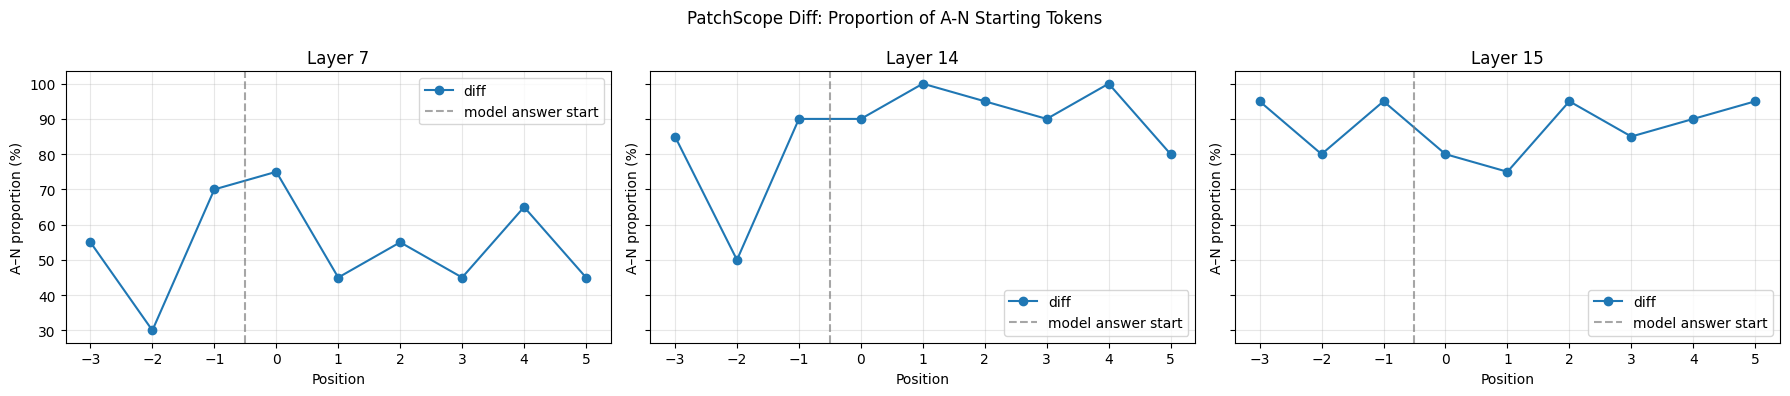

In [20]:
# Compute A-N proportion for PatchScope diff tokens across positions
ps_plot_data = {layer: {"positions": [], "diff_pct": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        ps_positions = discover_patchscope_positions(layer)
        if pos not in ps_positions and pos >= 0:
            # Try loading anyway; use 0 if not available
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue
        else:
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue

        diff_col = df["diff"].dropna()
        total = len(diff_col[diff_col != ""])
        a_n_count = 0
        for entry in diff_col:
            if not entry:
                continue
            token = entry.split(" (")[0].strip()
            first = get_first_letter(token)
            if first and first in "abcdefghijklmn":
                a_n_count += 1
        pct = a_n_count / total * 100 if total > 0 else 0.0
        ps_plot_data[layer]["positions"].append(pos)
        ps_plot_data[layer]["diff_pct"].append(pct)
        print(f"Layer {layer}, pos {pos}: {a_n_count}/{total} = {pct:.1f}%")

# Plot
fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        ps_plot_data[layer]["positions"],
        ps_plot_data[layer]["diff_pct"],
        marker="o",
        label="diff",
        color="tab:blue",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("A–N proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("PatchScope Diff: Proportion of A-N Starting Tokens")
plt.tight_layout()
plt.show()

### 2B. Aggregated Across All PatchScope Positions

Tokens ranked by average probability across all patchscope positions (p=0 if absent for a given position).  
Green checkmark if the token was in `selected_tokens` for **any** position.  
Format: `token (avg_prob)`

In [21]:
def patchscope_aggregated_single(layer):
    ps_positions = discover_patchscope_positions(layer)
    n_ps = len(ps_positions)

    cols = {}
    for col_name, prefix in PS_VARIANTS:
        token_prob_sum = defaultdict(float)
        ever_selected = set()
        for pos in ps_positions:
            data = load_patchscope(layer, pos, prefix)
            tokens = data["tokens_at_best_scale"]
            probs = data["token_probs"]
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
            ever_selected.update(_normalize_token(t) for t in data["selected_tokens"])

        token_avg = {t: s / n_ps for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            + (" \u2705" if _normalize_token(t) in ever_selected else "")
            for t in sorted_tokens
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_aggregated():
    dfs = []
    for layer in LAYERS:
        df = patchscope_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


ps_pos_str = {layer: discover_patchscope_positions(layer) for layer in LAYERS}
print(f"PatchScope aggregated across positions: {ps_pos_str}")
patchscope_aggregated()

PatchScope aggregated across positions: {7: [0, 1, 2, 3, 4, 5], 14: [0, 1, 2, 3, 4, 5], 15: [0, 1, 2, 3, 4, 5]}


layer_7                             \
                         base                         ft   
0                 -> (0.0518)                -> (0.1140)   
1              :\n\n (0.0311)            '\n\n' (0.0255)   
2                 's (0.0273)              '\n' (0.0229)   
3         /problem (0.0256) ✅         problem (0.0225) ✅   
4        /entities (0.0162) ✅        /problem (0.0173) ✅   
5        /problems (0.0158) ✅             :\n\n (0.0138)   
6            solve (0.0153) ✅       /entities (0.0119) ✅   
7                the (0.0127)       /problems (0.0106) ✅   
8          problem (0.0106) ✅             the (6.76e-03)   
9        /manage (9.52e-03) ✅               , (6.16e-03)   
10          '\n\n' (9.43e-03)             :\n (5.71e-03)   
11               , (9.22e-03)   <|endoftext|> (4.38e-03)   
12             you (7.72e-03)       /manage (4.24e-03) ✅   
13             :\n (7.22e-03)              is (3.72e-03)   
14           seems (6.23e-03)      question (3.55e-03) ✅   
15     statement (5.71e-03) ✅          .Today (3.23e-03)   
16    understand (4.85e-03) ✅               : (2.90e-03)   
17          .Today (4.75e-03)       /global (2.90e-03) ✅   
18        solves (3.78e-03) ✅      problems (2.86e-03) ✅   
19            '\n' (3.68e-03)     statement (2.61e-03) ✅   
20              is (3.67e-03)     /provider (2.16e-03) ✅   
21       /global (3.66e-03) ✅           .\n\n (2.15e-03)   
22  /preferences (3.28e-03) ✅        puzzle (1.91e-03) ✅   
23       address (2.80e-03) ✅        /legal (1.90e-03) ✅   
24      question (2.74e-03) ✅      solution (1.74e-03) ✅   
25              ’s (2.74e-03)      /logging (1.73e-03) ✅   
26     /provider (2.68e-03) ✅       /crypto (1.58e-03) ✅   
27            your (2.40e-03)          /job (1.57e-03) ✅   
28       /crypto (2.12e-03) ✅   /connection (1.36e-03) ✅   
29          /job (1.88e-03) ✅       /shared (1.32e-03) ✅   
30               : (1.86e-03)          task (1.27e-03) ✅   
31   /connection (1.81e-03) ✅  /environment (1.21e-03) ✅   
32       /object (1.74e-03) ✅            /man (1.19e-03)   
33       /layout (1.72e-03) ✅  /preferences (1.18e-03) ✅   
34       analyze (1.70e-03) ✅            this (1.15e-03)   
35              we (1.68e-03)             ' ' (1.14e-03)   
36      /effects (1.60e-03) ✅  /application (1.11e-03) ✅   
37        tackle (1.54e-03) ✅     /activity (1.06e-03) ✅   
38             /pr (1.51e-03)       example (9.55e-04) ✅   
39         break (1.48e-03) ✅       puzzles (9.36e-04) ✅   
40       /engine (1.37e-03) ✅          step (9.14e-04) ✅   
41  /application (1.20e-03) ✅          math (8.83e-04) ✅   
42      solution (1.18e-03) ✅         content (8.29e-04)   
43      /logging (1.15e-03) ✅               a (8.04e-04)   
44            /con (1.13e-03)              in (7.83e-04)   
45       /shared (1.09e-03) ✅      /testing (7.15e-04) ✅   
46          task (1.08e-03) ✅       /object (6.82e-04) ✅   
47        /legal (1.06e-03) ✅         /disc (6.76e-04) ✅   
48         appears (1.03e-03)       /layout (6.12e-04) ✅   
49          math (1.02e-03) ✅          /reg (6.12e-04) ✅   
50        answer (9.88e-04) ✅      /company (5.66e-04) ✅   
51       /dialog (9.83e-04) ✅          .Round (5.61e-04)   
52        prompt (9.61e-04) ✅      /account (5.50e-04) ✅   
53      requires (8.82e-04) ✅             /pr (5.06e-04)   
54            /man (8.70e-04)       /entity (5.01e-04) ✅   
55      involves (8.12e-04) ✅  /controllers (4.95e-04) ✅   
56          begins (7.90e-04)      /effects (4.76e-04) ✅   
57        puzzle (7.31e-04) ✅       /dialog (4.67e-04) ✅   
58       example (7.29e-04) ✅       /engine (4.38e-04) ✅   
59      /testing (6.48e-04) ✅       broadly (3.24e-04) ✅   
60          step (6.31e-04) ✅          preced (3.09e-04)   
61  /environment (6.29e-04) ✅     generally (2.64e-04) ✅   
62          /reg (6.04e-04) ✅           would (2.64e-04)   
63  /controllers (5.76e-04) ✅             ish (2.53e-04)   
64     /activity (5.76e-04) ✅          .First (2.34e-04)   
65